# Proyecto Final

_Jorge III Altamirano Astorga - 175904_

In [338]:
from bs4 import BeautifulSoup
import bs4 as bs4
import requests
import sys
from dateutil import parser #esta lib es más útil que la de Python para interpretar fechas parciales, como las de Twitter
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from string import punctuation
from sklearn.model_selection  import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

## BMV IPC

In [149]:
ipc = pd.read_csv("bmv_ipc.csv", sep=',')
ipc.Date = pd.to_datetime(ipc.Date)
#quitamos columnas menos relevantes para nuestro análisis
ipc = ipc.drop(["Open", "High", "Low", "Close"], axis=1)
#quito espacios
ipc = ipc.rename({"Adj Close": "close", "Volume": "volume", "Date": "date"}, axis="columns")
#sacamos la diferencia porcentual del cierre del día anterior
ipc["deltaPct"] = 100 * (1 - ipc["close"].shift(1) / ipc["close"])
ipc.dtypes

date        datetime64[ns]
close              float64
volume             float64
deltaPct           float64
dtype: object

In [150]:
ipc.describe()

,close,volume,deltaPct
count,1801.000000,1.801000e+03,1799.000000
mean,44267.486607,1.995833e+08,0.002294
std,3480.070698,9.779755e+07,0.858639
min,36548.558594,0.000000e+00,-6.171380
25%,41691.191406,1.496039e+08,-0.460797
50%,44209.421875,1.830149e+08,0.022623
75%,47009.511719,2.303386e+08,0.519613
max,51713.378906,1.759968e+09,3.463701


### Comportamiento del IPC

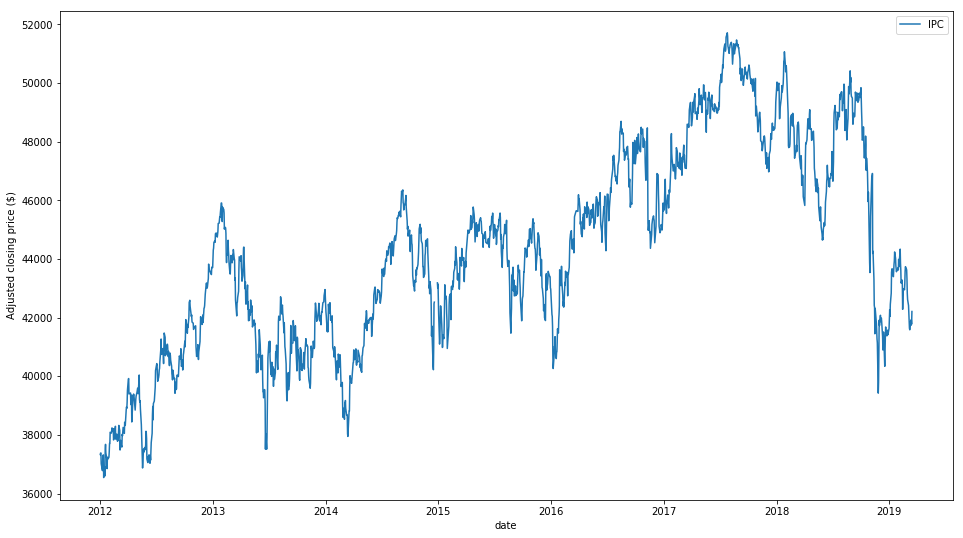

In [153]:
%matplotlib inline

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(ipc.date, ipc.close, label='IPC')
# ax.plot(short_rolling_msft.index, short_rolling_msft, label='20 days rolling')
# ax.plot(long_rolling_msft.index, long_rolling_msft, label='100 days rolling')

ax.set_xlabel('date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()
plt.show()

### Densidad

Hicimos una función _lag_ con el fin de comporar el cierre de una fecha con la del día anterior, esto de manera porcentual tienen una distribución la cual se observa como sigue.

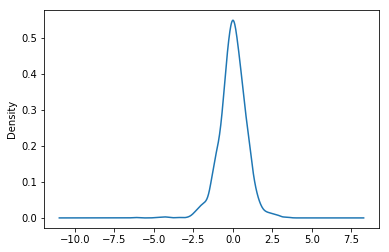

In [154]:
%matplotlib inline
ipc["deltaPct"].plot(kind="density")

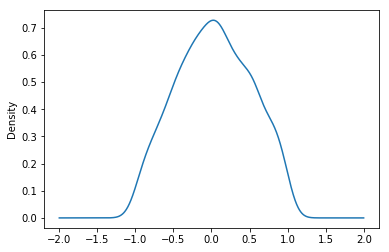

In [156]:
ipc.loc[(ipc.deltaPct >= -1.0) & (ipc.deltaPct <= 1.0), "deltaPct"].plot(kind="density")

Para nuestro análisis de sentimiento y su aprendizaje,
tendremos 3 sentimientos:
    * Negativo (-1): cuando el cambio en el IPC de la BMV sea menor o igual a -0.5% respecto al cierre del día anterior
    * Neutral (0): cuando el cambio en el IPC de la BMV sea mayor a -0.5% y menor a +0.5% respecto al cierre del día anterior
    * Positivo (+1): cuando el cambio en el IPC de la BMV sea mayor o igual a +0.5%
    
Estos números lo tomamos de la distribución de los datos, en los cuales el 25% 

**Nota:** crearemos una columna, la cual tendrá el posible análisis de sentimiento, el cual posteriormente aplicaremos el modelo de Lenguaje Natural, para intentar extraer el sentimiento basado en el comportamiento del día anterior y los tweets que mencionen palabras clave relacionados con la BMV.

In [183]:
ipc.loc[ipc.deltaPct <= -0.5, "sentiment"] = -1
ipc.loc[ipc.deltaPct >= +0.5, "sentiment"] = 1
ipc.loc[ipc.sentiment.isna(), "sentiment"] = 0
ipc.head()

,date,close,volume,deltaPct,sentiment
0,2012-01-02,37335.031250,17919600.0,NaN,0.0
1,2012-01-03,37384.339844,140639000.0,0.131896,0.0
2,2012-01-04,37387.628906,150435200.0,0.008797,0.0
3,2012-01-05,37017.949219,187662600.0,-0.998650,-1.0
4,2012-01-09,36785.339844,150829600.0,-0.632343,-1.0


## Sentiment Analysis

### Extracción y Obtención de Tweets

In [2]:
def extract_tweets(soup, file, i, year):
    tweets = soup.find_all("table", attrs={"class": "tweet"})
    # soup.find_all("div", attrs={"class": "tweet-text"})
    # tweet = tweets[0]
    for tweet in tweets:
        tweet_text = tweet.find_all('div', attrs={'class': 'tweet-text'})
        tweet_date = tweet.find_all("td", attrs={'class': 'timestamp'})
        for text in tweet_text:
            if type(text) == bs4.element.Tag:
                txt = re.sub("(eleconomista\.com\.mx|pic\.twitter\.com|bit\.ly|bitly\.com)/[^ ]*", " ", text.text).strip()
                txt = re.sub("(\||\n)", " ", txt)
                file.write(txt + "|")
        for date in tweet_date:
            if type(date) == bs4.element.Tag:
                date = date.text.strip() 
                date = re.sub(year[-2:] + "$", "", date)
                file.write(str(parser.parse(date + " " + year) )  + "|%s"%i + "\n")
                
# get_tweets(year="2019", filename="bmv.eleconomista")

In [3]:
def get_tweets(query="bolsa OR IPC OR BMV", newspaper="elfinanciero_mx", year="2018", filename="file"):
    q = 'https://mobile.twitter.com/search?q=' + query + \
          '%20from%3A' + newspaper + \
          '%20since%3A'+year+'-01-01%20until%3A'+year+'-12-31&src=typd&lang=en'

    with open("%s.%s.csv"%(filename,year), "wt") as file:
        i = 0
        q = 'https://mobile.twitter.com/search?q=' + query + \
        '%20from%3A' + newspaper + '%20since%3A' + year + \
        '-01-01%20until%3A' + year +'-12-31&src=typd&lang=en'
        file.write("tweet|time|page\n") #header
        while(True): #loop para extraer todas las páginas 
            print("  Downloading page %d..."%(i+1))
            try:
                response = requests.get(q)
            except:
                raise Exception("Error al obtener página de resultados.")
            if response.status_code != 200:
                raise Exception("Error (!= 200) al obtener página de resultados.")
            soup = BeautifulSoup(response.text, 'lxml') #abre la primera página de búsqueda de twitter
            extract_tweets(soup, file, i, year)

            #with open("%s_%d.html"%(query,i), 'w') as html:
            #    html.write(response.text)

            nx = soup.find("a", text=" Load older Tweets ")
            if nx != None and nx.has_attr('href'):
                q = "https://mobile.twitter.com" + nx.get_attribute_list('href')[0]
            else:
                break
            i += 1
    print("  Done!")

In [4]:
for yr in ["2014", "2015", "2016"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query="bolsa OR IPC OR BMV", newspaper=source, year=yr, filename="bmv.%s"%source)

  Done!
  Done!
  Done!
  Done!
  Done!
  Done!


### Limpiar columnas

In [319]:
df = pd.read_csv("bmv.elfinanciero_mx.2014.csv", sep="|")
df = df.append(pd.read_csv("bmv.elfinanciero_mx.2015.csv", sep="|"))
df = df.append(pd.read_csv("bmv.elfinanciero_mx.2016.csv", sep="|"))
df = df.append(pd.read_csv("bmv.elfinanciero_mx.2017.csv", sep="|"))
df = df.append(pd.read_csv("bmv.elfinanciero_mx.2018.csv", sep="|"))
df = df.append(pd.read_csv("bmv.elfinanciero_mx.2019.csv", sep="|"))
df["source"] = "elfinanciero_mx"
df = df.append(pd.read_csv("bmv.eleconomista.2014.csv", sep="|"))
df = df.append(pd.read_csv("bmv.eleconomista.2015.csv", sep="|"))
df = df.append(pd.read_csv("bmv.eleconomista.2016.csv", sep="|"))
df = df.append(pd.read_csv("bmv.eleconomista.2017.csv", sep="|"))
df = df.append(pd.read_csv("bmv.eleconomista.2018.csv", sep="|"))
df = df.append(pd.read_csv("bmv.eleconomista.2019.csv", sep="|"))
df["source"] = np.where(pd.isna(df["source"]), "eleconomista", df.source)
df.time = pd.to_datetime(df.time)
df.tweet = df.tweet.astype("str")
df.source = df.source.astype("str")
df = df.drop(columns=["page"])
df.dtypes

source            object
time      datetime64[ns]
tweet             object
dtype: object

In [320]:
#ordenar columnas 
df = df.sort_values(by=["time"])
#reindizar
df.index = range(0, df.shape[0])
# print(df.head(5))
(df.tail(5))

,source,time,tweet
2346,eleconomista,2019-03-14,"Por ser día feriado, el próximo lunes 18 de ma..."
2347,eleconomista,2019-03-14,El índice referencia S&P/BMV IPC retrocedió -0...
2348,eleconomista,2019-03-14,Uber Technologies Inc planea lanzar su oferta ...
2349,eleconomista,2019-03-15,#Volaris es la emisora con mayor rendimiento e...
2350,elfinanciero_mx,2019-03-15,#PorSiNoLoViste @Uber le 'pisa los talones' a ...


In [321]:
df.to_csv("tweets.csv.xz", compression="xz", index=False)
df.shape

(2351, 3)

## NLP

De manera experimental realizaremos un entrenamiento con el sentimiento que obtuvimos en el paso anterior (IPC), y lo asignaremos a los valores de la misma fecha del tweet.

In [324]:
df.drop(columns=["sentiment"], inplace=True, errors="ignore")
df["sentiment"] = df.join(ipc.set_index("date"), on="time", how="left").sentiment
df.head()

,source,time,tweet,sentiment
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival,NaN
1,elfinanciero_mx,2014-01-02,GRÁFICA. ¿Quiénes ganaron y quiénes perdieron ...,-1.0
2,elfinanciero_mx,2014-01-02,#Mercados #BMV cae 1.12% por toma de utilidade...,-1.0
3,elfinanciero_mx,2014-01-02,#Mercados #BMV avanza 0.22% en primer sesión d...,-1.0
4,elfinanciero_mx,2014-01-02,10 ganadoras y 10 perdedoras en la #BMV durant...,-1.0


Existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

In [332]:
i = -1
while np.any(df.sentiment.isna()):
    df["sent_lag"] = df.shift(i).sentiment
    df.loc[df.sentiment.isna(), "sentiment"] = df.loc[df.sentiment.isna(), "sent_lag"]
    i -= 1
df.drop(columns="sent_lag", inplace=True, errors="ignore")
df.head()

,source,time,tweet,sentiment
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival,-1.0
1,elfinanciero_mx,2014-01-02,GRÁFICA. ¿Quiénes ganaron y quiénes perdieron ...,-1.0
2,elfinanciero_mx,2014-01-02,#Mercados #BMV cae 1.12% por toma de utilidade...,-1.0
3,elfinanciero_mx,2014-01-02,#Mercados #BMV avanza 0.22% en primer sesión d...,-1.0
4,elfinanciero_mx,2014-01-02,10 ganadoras y 10 perdedoras en la #BMV durant...,-1.0


Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [334]:
train, test = train_test_split(df.tweet, test_size=0.4, random_state=175904)
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train.shape[0], 100*train.shape[0]/df.shape[0], 
    test.shape[0], 100*test.shape[0]/df.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 1410 (59.974479%)
Prueba: 941 (40.025521%)


Dado que El Financiero y El Economista publican en español utilizaremos las reglas y raíces de este nuestro idioma.

In [340]:
stop_words = stopwords.words('spanish')
stemmer = nltk.stem.SnowballStemmer('spanish')
non_words = list(punctuation)
non_words.extend(['¿', '¡'])

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens = word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize,
                             lowercase = True, stop_words = stop_words)